In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
import string
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import GridSearchCV

In [2]:
import nltk

for package in ['stopwords','punkt','wordnet']:
    nltk.download(package)
    
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english')) 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\desla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\desla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\desla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Project 1 - NLP and Text Classification

For this project you will need to classify some angry comments into their respective category of angry. The process that you'll need to follow is (roughly):
<ol>
<li> Use NLP techniques to process the training data. 
<li> Train model(s) to predict which class(es) each comment is in.
    <ul>
    <li> A comment can belong to any number of classes, including none. 
    </ul>
<li> Generate predictions for each of the comments in the test data. 
<li> Write your test data predicitions to a CSV file, which will be scored. 
</ol>

You can use any models and NLP libraries you'd like. Think aobut the problem, look back to see if there's anything that might help, give it a try, and see if that helps. We've regularly said we have a "toolkit" of things that we can use, we generally don't know which ones we'll need, but here you have a pretty simple goal - if it makes it more accurate, it helps. There's not one specific solution here, there are lots of things that you could do. 

## Training Data

Use the training data to train your prediction model(s). Each of the classification output columns (toxic to the end) is a human label for the comment_text, assessing if it falls into that category of "rude". A comment may fall into any number of categories, or none at all. Membership in one output category is <b>independent</b> of membership in any of the other classes (think about this when you plan on how to make these predictions - it may also make it easier to split work amongst a team...). 

In [3]:
train_df = pd.read_csv("train.csv.zip")
train_df

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [4]:
train_df_sub = train_df[:80000]
train_df_sub

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
79995,d611fd181ea47d1e,"""\n\nImage copyright problem RE: Image:Zeorin....",0,0,0,0,0,0
79996,d6122f277b3ac1b1,Not according to F8.,0,0,0,0,0,0
79997,d612437220d5df26,"Thank you for your apology. I accept it, such ...",0,0,0,0,0,0
79998,d612c65de883d4f5,REDIRECT Talk:Sweat Monkey Sex,1,0,1,0,0,0


In [7]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


In [5]:
vec_cv = CountVectorizer(max_features=150)
tmp = vec_cv.fit_transform(train_df["comment_text"])
tok_cols = vec_cv.get_feature_names_out()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:",train_df["comment_text"].shape)
print("vectorized:", tmp.shape)
tok_df.head(10)

original: (159571,)
vectorized: (159571, 150)


,about,add,after,again,all,also,am,an,and,any,...,who,why,wikipedia,will,with,work,would,wp,you,your
0,0,0,1,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,2,...,0,0,1,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,2,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
7,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,2,0
9,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
stop_words = list(set(stopwords.words('english') + list(string.punctuation)))
vec_tf = TfidfVectorizer(max_features=300, stop_words=stop_words)
tmp = vec_tf.fit_transform(train_df["comment_text"])
tok_cols = vec_tf.get_feature_names_out()
tok_df = pd.DataFrame(tmp.toarray(), columns=tok_cols)
print("original:", train_df["comment_text"].shape)
print("vectorized:", tmp.shape)
tok_df.head(10)

original: (159571,)
vectorized: (159571, 300)


,account,actually,add,added,adding,address,admin,agree,already,also,...,would,wp,write,written,wrong,www,year,years,yes,yet
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.186751,0.0,0.300303,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18919
           1       0.89      0.42      0.57      1081

    accuracy                           0.97     20000
   macro avg       0.93      0.71      0.78     20000
weighted avg       0.96      0.97      0.96     20000



<Axes: >

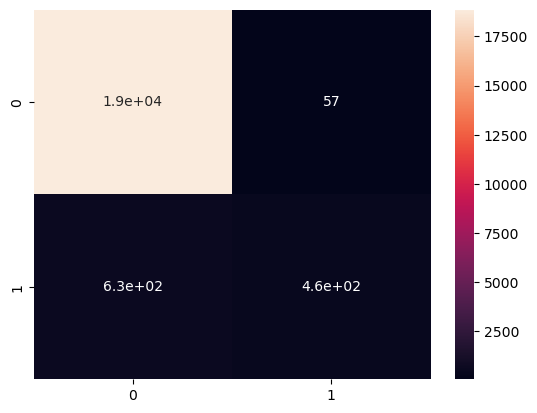

In [6]:
from sklearn.svm import SVC
model_svc = SVC()

stop_words = list(set(stopwords.words('english') + list(string.punctuation)))
vec_tf = TfidfVectorizer(max_features=300, stop_words=stop_words, ngram_range=(1,3))

y_obscene = train_df_sub["obscene"]
X_obscene = train_df_sub["comment_text"]

X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_obscene, y_obscene)

pipe_obscene = Pipeline([ 
                    ("vect", vec_tf),
                    ("model", model_svc)
])

params = ["vec_cv"]

pipe_obscene.fit(X_train_o, y_train_o.ravel())
model1 = pipe_obscene.predict(X_test_o)


In [ ]:
model_svc = SVC()

stop_words = list(set(stopwords.words('english') + list(string.punctuation)))
vec_tf = TfidfVectorizer(max_features=300, stop_words=stop_words, ngram_range=(1,3))

y_threat = train_df_sub["threat"]
X_threat = train_df_sub["comment_text"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_threat, y_threat)

pipe_threat = Pipeline([ 
                    ("vect", vec_tf),
                    ("model", model_svc)
])

params = ["vec_cv"]

pipe_threat.fit(X_train_t, y_train_t.ravel())
model2 = pipe_threat.predict(X_test_t)



In [10]:
obscene_test = pipe_obscene.predict(test_df['comment_text'])
threat_test = pipe_threat.predict(test_df['comment_text'])

In [27]:
new_df = pd.DataFrame(obscene_test, columns=['obscene'])
new_df['text'] = test_df['comment_text']
new_df['id'] = test_df['id']
new_df['threat'] = threat_test
new_df = new_df[['id', 'text', 'obscene', 'threat']]
new_df.head(10)

,id,text,obscene
0,1,Yo bitch Ja Rule is more succesful then you'll...,1
1,2,== From RfC == \n\n The title is fine as it is...,0
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap...",0
3,4,":If you have a look back at the source, the in...",0
4,5,I don't anonymously edit articles at all.,0
5,6,Thank you for understanding. I think very high...,0
6,7,Please do not add nonsense to Wikipedia. Such ...,0
7,8,:Dear god this site is horrible.,0
8,9,""" \n Only a fool can believe in such numbers. ...",0
9,10,== Double Redirects == \n\n When fixing double...,0


In [24]:
class swTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(tok)
        return filtered_tok

In [14]:
class stemTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import SnowballStemmer
        self.stemmer = SnowballStemmer(language='english')
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.stemmer.stem(tok))
        return filtered_tok

In [15]:
class lemmaTokenizer(object):
    def __init__(self, stop_words):
        self.stop_words = stop_words
        from nltk.stem import WordNetLemmatizer
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, doc):
        tokens = word_tokenize(doc)
        filtered_tok = []
        for tok in tokens:
            if tok not in stop_words:
                filtered_tok.append(self.lemmatizer.lemmatize(tok))
        return filtered_tok

In [16]:
vec_tf = TfidfVectorizer()

y = train_df_sub["obscene"]
X = train_df_sub["comment_text"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pipe2 = Pipeline([ 
                    #("vect", vec_cv),
                    ("vect", vec_tf),
                    ("model", model_svc)
])

params = {"vect__max_features":[100,500,1000,1500],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            "vect__norm":["l1","l2"]
            }

grid = GridSearchCV(estimator  = pipe2, 
                               param_grid = params, 
                               scoring    = "balanced_accuracy",
                               cv         = 5,
                               n_jobs     =-1)

grid.fit(X_train, y_train.ravel())
best = grid.best_estimator_
preds = best.predict(X_test)
print(best)
print(classification_report(y_test, preds))
sns.heatmap(confusion_matrix(y_test, preds), annot=True)

In [14]:
vec_tf3 = TfidfVectorizer()
model_svc3 = SVC()
 
pipe3 = Pipeline([
                    ("vect", vec_tf3),
                    ("model", model_svc3)
])
 
params3 = {"vect__max_features":[100,500,1000],
            "vect__tokenizer":(swTokenizer(stop_words), stemTokenizer(stop_words), lemmaTokenizer(stop_words) ),
            "vect__norm":["l1","l2"]
            }
 
grid3 = GridSearchCV(estimator  = pipe3,
                               param_grid = params3,
                               scoring    = "balanced_accuracy",
                               cv         = 5,
                               n_jobs     =-1)
 
grid3.fit(X_train, y_train)
best3 = grid3.best_estimator_
preds3 = best3.predict(X_test)
print(best3)
print(classification_report(y_test, preds3))
sns.heatmap(confusion_matrix(y_test, preds3), annot=True)

KeyboardInterrupt: 

## Test Data

In [11]:
test_df = pd.read_csv("test.csv")
test_df.head()

,id,comment_text
0,1,Yo bitch Ja Rule is more succesful then you'll...
1,2,== From RfC == \n\n The title is fine as it is...
2,3,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,4,":If you have a look back at the source, the in..."
4,5,I don't anonymously edit articles at all.


## Output Details, Submission Info, and Example Submission

For this project, please output your predictions in a CSV file. The structure of the CSV file should match the structure of the example below. 

The output should contain one row for each row of test data, complete with the columns for ID and each classification.

Into Moodle please submit:
<ul>
<li> Your notebook file(s). I'm not going to run them, just look. 
<li> Your sample submission CSV. This will be evaluated for accuracy against the real labels; only a subset of the predictions will be scored. 
</ul>

It is REALLY, REALLY, REALLY important the the structure of your output matches the specifications. The accuracies will be calculated by a script, and it is expecting a specific format. 

### Sample Evaluator

The file prediction_evaluator.ipynb contains an example scoring function, scoreChecker. This function takes a sumbission and an answer key, loops through, and evaluates the accuracy. You can use this to verify the format of your submission. I'm going to use the same function to evaluate the accuracy of your submission, against the answer key (unless I made some mistake in this counting function).

In [14]:
#Construct dummy data for a sample output. 
#You won't do this part first, you have real data - I'm faking it. 
#Your data should have the same structure, so the CSV output is the same
dummy_ids = ["dfasdf234", "asdfgw43r52", "asdgtawe4", "wqtr215432"]
dummy_toxic = [0,0,0,0]
dummy_severe = [0,0,0,0]
dummy_obscene = [0,1,1,0]
dummy_threat = [0,1,0,1]
dummy_insult = [0,0,1,0]
dummy_ident = [0,1,1,0]
columns = ["id", "toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
sample_out = pd.DataFrame( list(zip(dummy_ids, dummy_toxic, dummy_severe, dummy_obscene, dummy_threat, dummy_insult, dummy_ident)),
                    columns=columns)
sample_out.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,dfasdf234,0,0,0,0,0,0
1,asdfgw43r52,0,0,1,1,0,1
2,asdgtawe4,0,0,1,0,1,1
3,wqtr215432,0,0,0,1,0,0


In [13]:
#Write DF to CSV. Please keep the "out.csv" filename. Moodle will auto-preface it with an identifier when I download it. 
#This command should work with your dataframe of predictions. 
sample_out.to_csv('out.csv', index=False)  

## Grading

The grading for this is split between accuracy and well written code:
<ul>
<li> 75% - Accuracy. The most accurate will get 100% on this, the others will be scaled down from there. 
<li> 25% - Code quality. Can the code be followed and made sense of - i.e. comments, sections, titles. 
</ul>